# Applied Data Science Capstone (Coursera)

*This notebook for the assignment specified in Weeks 4 and 5*

The aim of this assignment is to explore, segment, and cluster the neighborhoods in the city of **Calgary, Alberta, Canada**. However, unlike New York, the neighborhood data is not readily available on the internet. For the Calgary neighborhood data, a Wikipedia [page](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_T) exists that has all the information we need to explore and cluster the neighborhoods in Calgary. 

---

## Part 1: Obtain the data from the Wikipedia page and create a working dataframe.

The first thing to do is to scrape the Wikipedia page and wrangle the data, clean it, and then read it into a pandas  dataframe so that it is in a structured format like the New York City dataset. The link to the Wikipedia page is https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_T.

The following libraries shown in the code cell below is required for this project. Please ensure that you have these libraries installed beforehand before running the next code. The website for [PyPI, the Python Package Index](https://pypi.org/) provides instructions on how to install these libraries.

Import the required libraries for the project:

In [2]:
from bs4 import BeautifulSoup
import requests
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import folium
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline 
from sklearn.cluster import KMeans 
from kneed import KneeLocator
from geopy.geocoders import Nominatim 

print('All libraries have been imported.')

All libraries have been imported.


The **requests library** is used to collect data from the assigned webpage, as specified by the ```URL``` variable in the cell below. The ```request.get()``` method was used to obtain the data from the webpage and the result assigned to the ```response``` variable. 

In [3]:
URL = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_T"
response = requests.get(URL)

In the cell below, the ```status_code``` attribute of the ```response``` variable was called to check if the webpage was downloaded successfully. The returned code of ```200``` shows that the webpage downloaded successfully. 

In [4]:
response.status_code

200

Next, using Python’s built-in ```html.parser```, the ```response.text``` document was parsed to obtain a nested data structure. This is assigned to the variable ```soup```.

In [5]:
soup = BeautifulSoup(response.text, 'html.parser')

To check that the correct webpage was scraped, the ```title``` attribute of the ```soup```variable was called.

In [6]:
print(soup.title)

<title>List of postal codes of Canada: T - Wikipedia</title>


On the Wikipedia [page](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M), HTML elements for each item can be viewed by inspecting the source. This can be done by hitting the buttons ```CTRL``` + ```SHIFT``` + ```I```, which opens the ```Developer Tools``` pane. Viewing the contents of the webpage and the  ```Developer Tools``` pane side by side makes it easier to read the HTML. Within the pane, the elements can be expanded and collapsed as desired to view the contents by clicking on the little gray riangular button. When the mouse cursor hovers over and scrolls down the list of HTML elements in the ```Developer Tools``` pane, the webpage's contents will be highlighted, which makes it easier to identify the block of HTML elements corresponding table. The elements identifying the table are: ```<table class="wikitable sortable jquery-tablesorter">```.

The ```find``` method is then used to obtain the table using the attributes specified by the ```class``` and the result assigned to the ```table``` variable.

In [7]:
table = soup.find("table", attrs={"class": "wikitable"})

The ```<tr>``` tag defines a table row. The ```find_all()``` method is used to idenfity and extract all rows using the string, "tr", from the table body (defined by the attribute, ```tbody```). The result is passed to the ```rows``` variable and the ```len``` function used to count the number of rows in the table.

In [8]:
rows = table.tbody.find_all("tr")

In [9]:
print('The number of rows found in the table is', len(rows))

The number of rows found in the table is 181


The following code shows the contents of the first item in the ```rows``` variable.

In [10]:
print(rows[0])

<tr>
<th>Postal Code
</th>
<th>Borough
</th>
<th>Neighborhood
</th>
<th>Latitude
</th>
<th>Longitude
</th></tr>


The HTML tags need to be removed before creating the dataframe. A new variable called ```table_data``` is initialized and a ```for``` loop used to append each row after the HTML tags have been stripped and replaced by a tab ('\t').

In [11]:
table_data = []
for row in rows:
    table_data.append(row.text.replace('\n', '\t').strip())

A new dataframe called ```df``` was then made using **pandas**, as shown in the code below. The first 5 lines of the dataframe can be called using the ```.head()``` method.

In [12]:
df = pd.DataFrame(table_data, columns=['col1'])
df.head()

,col1
0,Postal Code\t\tBorough\t\tNeighborhood\t\tLati...
1,T1A\t\tMedicine Hat\t\tCentral Medicine Hat\t\...
2,"T2A\t\tCalgary\t\tPenbrooke Meadows, Marlborou..."
3,"T3A\t\tCalgary\t\tDalhousie, Edgemont, Hampton..."
4,T4A\t\tAirdrie\t\tEast Airdrie\t\t51.272450\t\...


The following cells contain codes to get the dataframe, ```df``` in the right format before it's used for any data wrangling or cleaning steps. A new dataframe is created with each substantial formatting step, to avoid having to re-make the original dataframe again if there was a mistake. Doing this also helps to keep track of the changes made to the original dataframe.

The contents of each row needs to be split using the tab delimiter, '\t'. A new dataframe, ```df1``` is created after the split.

In [13]:
df1 = df.col1.str.split('\t\t', expand=True)
df1

,0,1,2,3,4
0,Postal Code,Borough,Neighborhood,Latitude,Longitude
1,T1A,Medicine Hat,Central Medicine Hat,50.036460,-110.679250
2,T2A,Calgary,"Penbrooke Meadows, Marlborough",51.049680,-113.964320
3,T3A,Calgary,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.126060,-114.143158
4,T4A,Airdrie,East Airdrie,51.272450,-113.986980
...,...,...,...,...,...
176,T5Z,Edmonton,West Lake District,53.5966,-113.4882
177,T6Z,Not assigned,Not assigned,Not assigned,Not assigned
178,T7Z,Stony Plain,Not assigned,53.5202,-114.0135
179,T8Z,Not assigned,Not assigned,Not assigned,Not assigned


The contents of the first row is the header for each column. The following code extracts that information, passing it to a list called ```header```.

In [14]:
header = df1.iloc[0]
header

0     Postal Code
1         Borough
2    Neighborhood
3        Latitude
4       Longitude
Name: 0, dtype: object

A new dataframe, ```df2```, was created by extracting the rows from the second row onwards from ```df1```.

In [15]:
df2 = df1[1:]
df2

,0,1,2,3,4
1,T1A,Medicine Hat,Central Medicine Hat,50.036460,-110.679250
2,T2A,Calgary,"Penbrooke Meadows, Marlborough",51.049680,-113.964320
3,T3A,Calgary,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.126060,-114.143158
4,T4A,Airdrie,East Airdrie,51.272450,-113.986980
5,T5A,Edmonton,"West Clareview, East Londonderry",53.5899,-113.4413
...,...,...,...,...,...
176,T5Z,Edmonton,West Lake District,53.5966,-113.4882
177,T6Z,Not assigned,Not assigned,Not assigned,Not assigned
178,T7Z,Stony Plain,Not assigned,53.5202,-114.0135
179,T8Z,Not assigned,Not assigned,Not assigned,Not assigned


The ```header``` list is then used to name the columns in ```df2```.

In [16]:
df2.columns = header
df2

,Postal Code,Borough,Neighborhood,Latitude,Longitude
1,T1A,Medicine Hat,Central Medicine Hat,50.036460,-110.679250
2,T2A,Calgary,"Penbrooke Meadows, Marlborough",51.049680,-113.964320
3,T3A,Calgary,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.126060,-114.143158
4,T4A,Airdrie,East Airdrie,51.272450,-113.986980
5,T5A,Edmonton,"West Clareview, East Londonderry",53.5899,-113.4413
...,...,...,...,...,...
176,T5Z,Edmonton,West Lake District,53.5966,-113.4882
177,T6Z,Not assigned,Not assigned,Not assigned,Not assigned
178,T7Z,Stony Plain,Not assigned,53.5202,-114.0135
179,T8Z,Not assigned,Not assigned,Not assigned,Not assigned


The index of ```df2``` was then reset, as shown below.

In [17]:
df2.reset_index(inplace=True)

In [18]:
df2

,index,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,1,T1A,Medicine Hat,Central Medicine Hat,50.036460,-110.679250
1,2,T2A,Calgary,"Penbrooke Meadows, Marlborough",51.049680,-113.964320
2,3,T3A,Calgary,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.126060,-114.143158
3,4,T4A,Airdrie,East Airdrie,51.272450,-113.986980
4,5,T5A,Edmonton,"West Clareview, East Londonderry",53.5899,-113.4413
...,...,...,...,...,...,...
175,176,T5Z,Edmonton,West Lake District,53.5966,-113.4882
176,177,T6Z,Not assigned,Not assigned,Not assigned,Not assigned
177,178,T7Z,Stony Plain,Not assigned,53.5202,-114.0135
178,179,T8Z,Not assigned,Not assigned,Not assigned,Not assigned


After the index has been reset, a new column containing the previous index values was created ('index'). This column was then deleted using the ```.drop()``` method and the remaining columns passed to a new dataframe, ```df3```.

In [19]:
df3 = df2.drop('index', axis=1)

In [20]:
df3

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,T1A,Medicine Hat,Central Medicine Hat,50.036460,-110.679250
1,T2A,Calgary,"Penbrooke Meadows, Marlborough",51.049680,-113.964320
2,T3A,Calgary,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.126060,-114.143158
3,T4A,Airdrie,East Airdrie,51.272450,-113.986980
4,T5A,Edmonton,"West Clareview, East Londonderry",53.5899,-113.4413
...,...,...,...,...,...
175,T5Z,Edmonton,West Lake District,53.5966,-113.4882
176,T6Z,Not assigned,Not assigned,Not assigned,Not assigned
177,T7Z,Stony Plain,Not assigned,53.5202,-114.0135
178,T8Z,Not assigned,Not assigned,Not assigned,Not assigned


Now the dataframe is ready to be wrangled or cleaned as per the instructions set out in the assignment. Before starting, a new dataframe, ```df4``` was cloned from the correctly formatted dataframe, ```df3```.

In [21]:
df4 = df3[:]
df4.columns

Index(['Postal Code', 'Borough', 'Neighborhood', 'Latitude', 'Longitude'], dtype='object', name=0)

The following code shows the data types found in each column of the dataframe.

In [22]:
df4.dtypes

0
Postal Code     object
Borough         object
Neighborhood    object
Latitude        object
Longitude       object
dtype: object

The step was to only process the cells that have an assigned borough and ignore cells with a borough that is 'Not assigned'. The following code tests whether the column 'Borough' has the string, 'Not assigned' and returns a Boolean result for each row.

In [23]:
df4['Borough'] == 'Not assigned'

0      False
1      False
2      False
3      False
4      False
       ...  
175    False
176     True
177    False
178     True
179     True
Name: Borough, Length: 180, dtype: bool

Cells with the string 'Not assigned' in the column 'Borough' were dropped from the dataframe. The option ```inplace = True``` signifies that the dataframe is to be overwritten when the changes are made. The resulting dataframe is then checked to view the changes made.

In [24]:
df4.drop(df4[df4['Borough'] == 'Not assigned'].index, inplace = True) 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [25]:
df4

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,T1A,Medicine Hat,Central Medicine Hat,50.036460,-110.679250
1,T2A,Calgary,"Penbrooke Meadows, Marlborough",51.049680,-113.964320
2,T3A,Calgary,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.126060,-114.143158
3,T4A,Airdrie,East Airdrie,51.272450,-113.986980
4,T5A,Edmonton,"West Clareview, East Londonderry",53.5899,-113.4413
...,...,...,...,...,...
171,T1Z,Rocky View,Not assigned,Not assigned,Not assigned
172,T2Z,Calgary,"Douglas Glen, McKenzie Lake, Copperfield, East...",50.9023,-113.9873
173,T3Z,Redwood Meadows,Not assigned,50.9821,-114.5178
175,T5Z,Edmonton,West Lake District,53.5966,-113.4882


Another way to check if there are any cells with the string 'Not assigned' in the column 'Borough' is to use the ```.any()``` method. The resulting Boolean value, ```False```, shows that there is no cell with that string in the column.

In [26]:
(df4['Borough'] == 'Not assigned').any()

False

If a cell has a borough but a 'Not assigned'  neighborhood, then the neighborhood will be the same as the borough. As asbove, the ```.any()``` method was used on the column 'Neighbourhood' to check for the string. The resulting Boolean values shows that there are 45 cells (```True```) that do not have an assigned neighborhood.

In [27]:
(df4['Neighborhood'] == 'Not assigned').value_counts()

False    99
True     45
Name: Neighborhood, dtype: int64

For cells in the column 'Neighborhood' with the string 'Not assigned', the neighborhood will be the same as the borough. The following code iterates through the dataframe and replaces the 'Not assigned' string with the name of the borough.

In [28]:
df4.loc[df4['Neighborhood'] == ('Not assigned'), 'Neighborhood'] = df4['Borough']

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Checking again that there are all cells in the column 'Neighborhood' have names. The Boolean result, `False`, shows this to be true.

In [29]:
(df4['Neighborhood'] == 'Not assigned').value_counts()

False    144
Name: Neighborhood, dtype: int64

Looking at the table on the Wikipedia page, there were a few cells that have 'Not assigned' values in the columns, 'Latitude' and 'Longitude'. These have to be removed because the Foursquare API requires these coordinates. After dropping these rows, the dataframe is checked again to see if any cells in the columns 'Latitude' and 'Longitude' still have that string. The Boolean result, `False`, shows there is none.

In [30]:
(df4['Latitude'] == 'Not assigned').any()

True

In [31]:
(df4['Longitude'] == 'Not assigned').any()

True

In [32]:
df4.drop(df4[df4['Latitude'] == 'Not assigned'].index, inplace = True) 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [33]:
(df4['Latitude'] == 'Not assigned').any()

False

In [34]:
(df4['Longitude'] == 'Not assigned').any()

False

In [35]:
print('The current size of the dataframe is', df4.shape[0], 'rows and', df4.shape[1], 'columns.')

The current size of the dataframe is 138 rows and 5 columns.


The next step was to check if a postal code is shared by more than one neighbourhood. This is done using the `.nunique()` method.

In [36]:
df4['Postal Code'].nunique()

138

As the number of unique values in the column 'Postal Code' matches the number of rows, we can conclude that there are no duplicated postal codes in the columns.

In the last cell of this part, the ```.shape``` method is used to print the number of rows of the cleaned dataframe.

In [37]:
print('The data frame has', df4.shape[0], 'rows')

The data frame has 138 rows


--- 

## Part 2: Explore and cluster the neighborhoods in Calgary, Alberta. 

This part involves working with neighborhoods in the city and then replicate the same analysis done with the New York City data in the labs.

Renamed the dataframe created in Part 1 as ```neighborhoods```.

In [38]:
neighborhoods = df4[:]
neighborhoods.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,T1A,Medicine Hat,Central Medicine Hat,50.036460,-110.679250
1,T2A,Calgary,"Penbrooke Meadows, Marlborough",51.049680,-113.964320
2,T3A,Calgary,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.126060,-114.143158
3,T4A,Airdrie,East Airdrie,51.272450,-113.986980
4,T5A,Edmonton,"West Clareview, East Londonderry",53.5899,-113.4413


In [39]:
print('The data frame has', neighborhoods.shape[0], 'rows and', neighborhoods.shape[1], 'columns')

The data frame has 138 rows and 5 columns


First, the data for the borough, Calgary' was extracted from the `neighborhoods` dataframe and passed to a new dataframe called `calgary_data`. The data was then checked to ensure that it contained data for Calgary only.

In [40]:
calgary_data = neighborhoods[neighborhoods['Borough'].isin(['Calgary'])].reset_index(drop=True)
calgary_data.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,T2A,Calgary,"Penbrooke Meadows, Marlborough",51.049680,-113.964320
1,T3A,Calgary,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.126060,-114.143158
2,T2B,Calgary,"Forest Lawn, Dover, Erin Woods",51.0318,-113.9786
3,T3B,Calgary,"Montgomery, Bowness, Silver Springs, Greenwood",51.0809,-114.1616
4,T2C,Calgary,"Lynnwood Ridge, Ogden, Foothills Industrial, G...",50.9878,-114.0001


In [41]:
(calgary_data['Borough'] != 'Calgary')

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
Name: Borough, dtype: bool

The following code uses the **geopy library** to obtain the coordinates of Calgary in Alberta, Canada. In order to define an instance of the geocoder, a user_agent called <em>calgary_explorer</em> was created, as shown below.

In [42]:
address = 'Calgary, AB'

geolocator = Nominatim(user_agent="calgary_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Calgary are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Calgary are 51.0534234, -114.0625892.


The following code creates a map of Calgary using the **folium library**

In [43]:
map_calgary = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(calgary_data['Latitude'], calgary_data['Longitude'], calgary_data['Borough'], calgary_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_calgary)  
    
map_calgary

The Foursquare API was used to to explore these neighborhoods and segment them.

# Remove these before submitting notebook!!!

In [44]:
CLIENT_ID = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx' 
CLIENT_SECRET = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx' 
ACCESS_TOKEN = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx' 
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
CLIENT_SECRET:xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx


In [45]:
calgary_data

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,T2A,Calgary,"Penbrooke Meadows, Marlborough",51.049680,-113.964320
1,T3A,Calgary,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.126060,-114.143158
2,T2B,Calgary,"Forest Lawn, Dover, Erin Woods",51.0318,-113.9786
3,T3B,Calgary,"Montgomery, Bowness, Silver Springs, Greenwood",51.0809,-114.1616
4,T2C,Calgary,"Lynnwood Ridge, Ogden, Foothills Industrial, G...",50.9878,-114.0001
5,T3C,Calgary,"Rosscarrock, Westgate, Wildwood, Shaganappi, S...",51.0388,-114.098
6,T2E,Calgary,"Bridgeland, Greenview, Zoo, YYC",51.0632,-114.0614
7,T3E,Calgary,"Lakeview, Glendale, Killarney, Glamorgan",51.0227,-114.1342
8,T2G,Calgary,"Inglewood, Burnsland, Chinatown, East Victoria...",51.0415,-114.0599
9,T3G,Calgary,"Hawkwood, Arbour Lake, Citadel, Ranchlands, Ro...",51.1147,-114.1796


In [46]:
calgary_data.loc[22, 'Neighborhood']

'City Centre, Calgary Tower'

In [47]:
neighborhood_latitude = calgary_data.loc[22, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = calgary_data.loc[22, 'Longitude'] # neighborhood longitude value

neighborhood_name = calgary_data.loc[22, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of City Centre, Calgary Tower are 51.0472, -114.0802.


The following code gets the top 100 venues that are in City Centre, Calgary Tower within a radius of 500 meters.

In [48]:
LIMIT = 100 
radius = 500

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx&client_secret=xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx&v=20180605&ll=51.0472,-114.0802&radius=500&limit=100'

A GET request was sent to obtain the desired information, which was then passed to a variable called ```results```. 

In [49]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ffe686d55e19a6657e107e3'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Downtown Calgary',
  'headerFullLocation': 'Downtown Calgary, Calgary',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 28,
  'suggestedBounds': {'ne': {'lat': 51.0517000045, 'lng': -114.07305550247645},
   'sw': {'lat': 51.042699995499994, 'lng': -114.08734449752356}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '56fad28d498e6708ba9ce968',
       'name': 'Gyu-Kaku Japanese BBQ',
       'location': {'address': '638-6 Ave SW #100',
        'crossStreet': '6th St SW',
        'lat': 51.04793375888661,
        'lng': -114.07610976489984,
        'labeled

All the information that is needed can be found in the _items_ key. The **get_category_type** function is used to extract the category of the venues found.

In [50]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

The following code obtains the required information about the venues and structure that information into a _pandas_ dataframe.

In [51]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Gyu-Kaku Japanese BBQ,Japanese Restaurant,51.047934,-114.076110
1,MEC Calgary,Sporting Goods Shop,51.043992,-114.080740
2,Holy Grill,Sandwich Place,51.043623,-114.080692
3,Toa Vietnamese Cuisine,Vietnamese Restaurant,51.047512,-114.076117
4,Buchanan's,Steakhouse,51.050814,-114.078320


The following shows the number of venues returned by the Foursquare API.

In [52]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

28 venues were returned by Foursquare.


The following function repeat the same process used on City Centre, Calgary Tower to all the neighborhoods in Calgary.

In [53]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Running the ```getNearbyVenues``` prints out a list of all neighbourhoods found in Calgary, AB.

In [54]:
city_venues = getNearbyVenues(names=calgary_data['Neighborhood'], latitudes=calgary_data['Latitude'], longitudes=calgary_data['Longitude'])

Penbrooke Meadows, Marlborough
Dalhousie, Edgemont, Hamptons, Hidden Valley
Forest Lawn, Dover, Erin Woods
Montgomery, Bowness, Silver Springs, Greenwood
Lynnwood Ridge, Ogden, Foothills Industrial, Great Plains
Rosscarrock, Westgate, Wildwood, Shaganappi, Sunalta
Bridgeland, Greenview, Zoo, YYC
Lakeview, Glendale, Killarney, Glamorgan
Inglewood, Burnsland, Chinatown, East Victoria Park, Saddledome
Hawkwood, Arbour Lake, Citadel, Ranchlands, Royal Oak, Rocky Ridge
Highfield, Burns Industrial
Discovery Ridge, Signal Hill, West Springs, Christie Estates, Patterson, Cougar Ridge
Queensland, Lake Bonavista, Willow Park, Acadia
Martindale, Taradale, Falconridge, Saddle Ridge
Thorncliffe, Tuxedo Park
Sandstone, MacEwan Glen, Beddington, Harvest Hills, Coventry Hills, Panorama Hills
Brentwood, Collingwood, Nose Hill
Tuscany, Scenic Acres
Mount Pleasant, Capitol Hill, Banff Trail
Cranston, Auburn Bay, Mahogany
Kensington, Westmont, Parkdale, University
Northeast Calgary
City Centre, Calgary To

The following code cell shows that the new ```city_venues``` dataframe has 337 rows and 7 columns, while the ```.head()``` shows the first 5 rows.

In [55]:
print(city_venues.shape)
city_venues.head()

(331, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.126060,-114.143158,Petro-Canada,51.128068,-114.138057,Gas Station
1,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.126060,-114.143158,Edgemont City,51.126473,-114.138997,Asian Restaurant
2,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.126060,-114.143158,Friends Cappuccino Bar & Bake Shop,51.126370,-114.138676,Café
3,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.126060,-114.143158,Mac's,51.128309,-114.137902,Convenience Store
4,"Forest Lawn, Dover, Erin Woods",51.0318,-113.9786,Bonasera Pizza And Sports Bar,51.029893,-113.982543,Bar


The number of venues returned for each neighbourhood is as shown below:

In [56]:
city_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Braeside, Cedarbrae, Woodbine",9,9,9,9,9,9
"Brentwood, Collingwood, Nose Hill",1,1,1,1,1,1
"Bridgeland, Greenview, Zoo, YYC",22,22,22,22,22,22
"City Centre, Calgary Tower",28,28,28,28,28,28
"Connaught, West Victoria Park",42,42,42,42,42,42
"Cranston, Auburn Bay, Mahogany",3,3,3,3,3,3
"Dalhousie, Edgemont, Hamptons, Hidden Valley",4,4,4,4,4,4
"Discovery Ridge, Signal Hill, West Springs, Christie Estates, Patterson, Cougar Ridge",4,4,4,4,4,4
"Douglas Glen, McKenzie Lake, Copperfield, East Shepard",7,7,7,7,7,7


The following cell shows the code to obtain the number of unique categories found.

In [57]:
print('There are {} uniques categories.'.format(len(city_venues['Venue Category'].unique())))

There are 115 uniques categories.


In order to segment and cluster the neighborhoods on a map of Calgary, the categorical values in the ```city_venues``` dataframe needs to be converted to numerical values using one-hot encoding. A new dataframe called ```city_onehot``` is created. 

In [58]:
city_onehot = pd.get_dummies(city_venues[['Venue Category']], prefix="", prefix_sep="")
city_onehot['Neighborhood'] = city_venues['Neighborhood'] 
city_onehot.columns

Index(['American Restaurant', 'Art Gallery', 'Arts & Crafts Store',
       'Asian Restaurant', 'BBQ Joint', 'Bakery', 'Bank', 'Bar', 'Bistro',
       'Bookstore',
       ...
       'Tapas Restaurant', 'Tattoo Parlor', 'Thai Restaurant', 'Theater',
       'Vegetarian / Vegan Restaurant', 'Video Store', 'Vietnamese Restaurant',
       'Wine Shop', 'Yoga Studio', 'Neighborhood'],
      dtype='object', length=116)

In [59]:
cols = city_onehot.columns.tolist()
cols

['American Restaurant',
 'Art Gallery',
 'Arts & Crafts Store',
 'Asian Restaurant',
 'BBQ Joint',
 'Bakery',
 'Bank',
 'Bar',
 'Bistro',
 'Bookstore',
 'Brazilian Restaurant',
 'Breakfast Spot',
 'Brewery',
 'Bridal Shop',
 'Burger Joint',
 'Café',
 'Camera Store',
 'Candy Store',
 'Carpet Store',
 'Child Care Service',
 'Chinese Restaurant',
 'Chocolate Shop',
 'Clothing Store',
 'Cocktail Bar',
 'Coffee Shop',
 'Comedy Club',
 'Comic Shop',
 'Convenience Store',
 'Cosmetics Shop',
 'Curling Ice',
 'Deli / Bodega',
 'Department Store',
 'Dessert Shop',
 'Dim Sum Restaurant',
 'Diner',
 'Discount Store',
 'Dog Run',
 'Donut Shop',
 'Dry Cleaner',
 'Electronics Store',
 'Falafel Restaurant',
 'Fast Food Restaurant',
 'Flea Market',
 'Food Court',
 'Food Truck',
 'French Restaurant',
 'Fried Chicken Joint',
 'Furniture / Home Store',
 'Gas Station',
 'Gastropub',
 'Gay Bar',
 'Gift Shop',
 'Gourmet Shop',
 'Grocery Store',
 'Gym',
 'Gym / Fitness Center',
 'Hardware Store',
 'Health & B

In [60]:
cols.insert(0, cols.pop(cols.index('Neighborhood')))
cols

['Neighborhood',
 'American Restaurant',
 'Art Gallery',
 'Arts & Crafts Store',
 'Asian Restaurant',
 'BBQ Joint',
 'Bakery',
 'Bank',
 'Bar',
 'Bistro',
 'Bookstore',
 'Brazilian Restaurant',
 'Breakfast Spot',
 'Brewery',
 'Bridal Shop',
 'Burger Joint',
 'Café',
 'Camera Store',
 'Candy Store',
 'Carpet Store',
 'Child Care Service',
 'Chinese Restaurant',
 'Chocolate Shop',
 'Clothing Store',
 'Cocktail Bar',
 'Coffee Shop',
 'Comedy Club',
 'Comic Shop',
 'Convenience Store',
 'Cosmetics Shop',
 'Curling Ice',
 'Deli / Bodega',
 'Department Store',
 'Dessert Shop',
 'Dim Sum Restaurant',
 'Diner',
 'Discount Store',
 'Dog Run',
 'Donut Shop',
 'Dry Cleaner',
 'Electronics Store',
 'Falafel Restaurant',
 'Fast Food Restaurant',
 'Flea Market',
 'Food Court',
 'Food Truck',
 'French Restaurant',
 'Fried Chicken Joint',
 'Furniture / Home Store',
 'Gas Station',
 'Gastropub',
 'Gay Bar',
 'Gift Shop',
 'Gourmet Shop',
 'Grocery Store',
 'Gym',
 'Gym / Fitness Center',
 'Hardware Sto

In [61]:
city_onehot = city_onehot.reindex(columns= cols)

In [62]:
city_onehot.head()

,Neighborhood,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Bistro,...,Sushi Restaurant,Tapas Restaurant,Tattoo Parlor,Thai Restaurant,Theater,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Shop,Yoga Studio
0,"Dalhousie, Edgemont, Hamptons, Hidden Valley",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Dalhousie, Edgemont, Hamptons, Hidden Valley",0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Dalhousie, Edgemont, Hamptons, Hidden Valley",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Dalhousie, Edgemont, Hamptons, Hidden Valley",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Forest Lawn, Dover, Erin Woods",0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
print('The new city_onehot dataframe has', city_onehot.shape[0], 'rows and', city_onehot.shape[1], 'columns')

The new city_onehot dataframe has 331 rows and 116 columns


Following one-hot encoding of the dataframe, the rows are then grouped by neighborhood. The mean of the frequency of occurrence for each category in each neighbourhood is showed using the ```.mean()```.

In [64]:
city_grouped = city_onehot.groupby('Neighborhood').mean().reset_index()
city_grouped

,Neighborhood,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Bistro,...,Sushi Restaurant,Tapas Restaurant,Tattoo Parlor,Thai Restaurant,Theater,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Shop,Yoga Studio
0,"Braeside, Cedarbrae, Woodbine",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,"Brentwood, Collingwood, Nose Hill",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Bridgeland, Greenview, Zoo, YYC",0.000000,0.000000,0.000000,0.045455,0.000000,0.000000,0.090909,0.000000,0.000000,...,0.045455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045455,0.000000,0.000000
3,"City Centre, Calgary Tower",0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.071429,0.000000,...,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035714,0.000000,0.000000
4,"Connaught, West Victoria Park",0.000000,0.000000,0.000000,0.000000,0.000000,0.023810,0.000000,0.071429,0.000000,...,0.023810,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023810
5,"Cranston, Auburn Bay, Mahogany",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,"Dalhousie, Edgemont, Hamptons, Hidden Valley",0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,"Discovery Ridge, Signal Hill, West Springs, Ch...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000
8,"Douglas Glen, McKenzie Lake, Copperfield, East...",0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.142857,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,"Elbow Park, Britannia, Parkhill, Mission",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [65]:
print('The new city_grouped dataframe has', city_grouped.shape[0], 'rows and', city_grouped.shape[1], 'columns')

The new city_grouped dataframe has 33 rows and 116 columns


Repeating the grouping but this time, getting the total number of venues for each catergory per neighborhood.

In [66]:
city_grouped1 = city_onehot.groupby('Neighborhood').sum().reset_index()
city_grouped1

,Neighborhood,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Bistro,...,Sushi Restaurant,Tapas Restaurant,Tattoo Parlor,Thai Restaurant,Theater,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Shop,Yoga Studio
0,"Braeside, Cedarbrae, Woodbine",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Brentwood, Collingwood, Nose Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Bridgeland, Greenview, Zoo, YYC",0,0,0,1,0,0,2,0,0,...,1,0,0,0,0,0,0,1,0,0
3,"City Centre, Calgary Tower",0,0,0,0,0,2,0,2,0,...,2,0,0,0,0,0,0,1,0,0
4,"Connaught, West Victoria Park",0,0,0,0,0,1,0,3,0,...,1,0,0,0,0,0,0,0,0,1
5,"Cranston, Auburn Bay, Mahogany",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,"Dalhousie, Edgemont, Hamptons, Hidden Valley",0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,"Discovery Ridge, Signal Hill, West Springs, Ch...",0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
8,"Douglas Glen, McKenzie Lake, Copperfield, East...",0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9,"Elbow Park, Britannia, Parkhill, Mission",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In order to solve the business problem, columns related to restaurants from the `city_grouped` dataframe need to be extracted. The results were assigned the `restaurants` dataframe.

In [67]:
restaurants = city_grouped1.loc[:,city_grouped1.columns.str.contains("Restaurant")]
restaurants.head()

,American Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant,Italian Restaurant,...,Moroccan Restaurant,New American Restaurant,Restaurant,Scandinavian Restaurant,Seafood Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,1,1,2,0,1,0,...,0,0,1,0,1,1,0,0,0,1
3,0,0,0,0,0,0,0,0,0,1,...,1,0,2,0,0,2,0,0,0,1
4,0,0,1,1,0,0,0,2,0,1,...,1,0,2,1,0,1,0,0,0,0


Getting a total for each type of restaurant found in these neighborhoods and creating a dataframe with the data. The new dataframe, `res_count` is re-indexed and the columns renamed to indicate its contents.

In [68]:
res_count = restaurants[restaurants != 0].count()
res_count

American Restaurant              5
Asian Restaurant                 5
Brazilian Restaurant             2
Chinese Restaurant               6
Dim Sum Restaurant               1
Falafel Restaurant               2
Fast Food Restaurant             6
French Restaurant                1
Indian Restaurant                2
Italian Restaurant               5
Japanese Restaurant              1
Korean Restaurant                1
Mediterranean Restaurant         3
Mexican Restaurant               1
Middle Eastern Restaurant        6
Moroccan Restaurant              2
New American Restaurant          2
Restaurant                       5
Scandinavian Restaurant          1
Seafood Restaurant               2
Sushi Restaurant                 5
Tapas Restaurant                 1
Thai Restaurant                  1
Vegetarian / Vegan Restaurant    1
Vietnamese Restaurant            8
dtype: int64

In [69]:
res_count_df = pd.DataFrame(res_count)
res_count_df.head()

,0
American Restaurant,5
Asian Restaurant,5
Brazilian Restaurant,2
Chinese Restaurant,6
Dim Sum Restaurant,1


In [70]:
res_count_df.reset_index(inplace=True)
res_count_df.head()

,index,0
0,American Restaurant,5
1,Asian Restaurant,5
2,Brazilian Restaurant,2
3,Chinese Restaurant,6
4,Dim Sum Restaurant,1


In [71]:
res_count_df.columns = ['Restaurant Type', 'Count']
res_count_df.head()

,Restaurant Type,Count
0,American Restaurant,5
1,Asian Restaurant,5
2,Brazilian Restaurant,2
3,Chinese Restaurant,6
4,Dim Sum Restaurant,1


The **seaborn library** is then used to plot the data as shown below

<AxesSubplot:xlabel='Count', ylabel='Restaurant Type'>

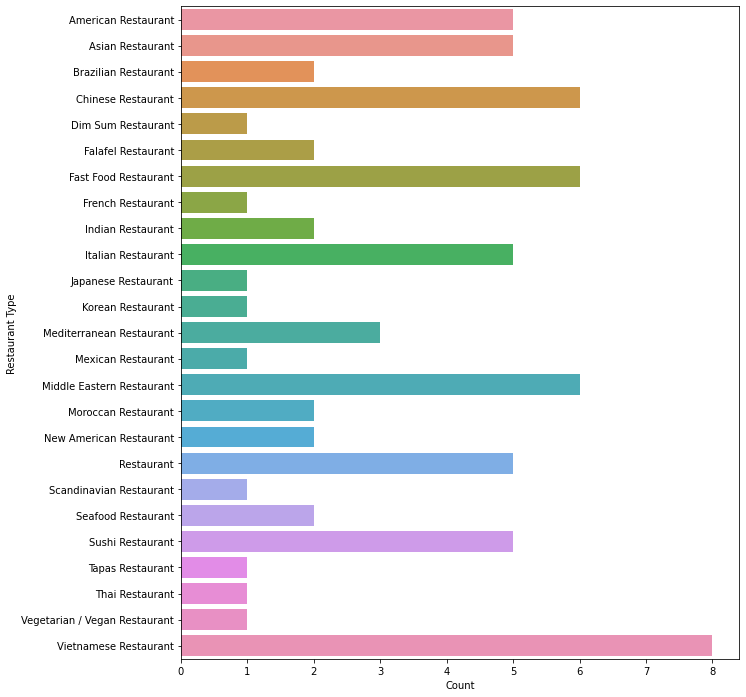

In [72]:
fig, ax = plt.subplots(figsize=(10,12))
sns.barplot(x="Count", y="Restaurant Type", data=res_count_df, ax=ax)

Collectively, the predominant type of retaurant in Calgary is Vietnamese, followed by Japanese, Sushi and Middle Eastern restaurants. Note that there may be an overlap in the cuisines as shown by the different categories. Moreover, one category (called simply 'Restaurant') does not provide any information on their cuisine type.

The dataframe can also be transposed to show the total number of restaurants for each neighborhood. However, the 'Neighbourhood' columns need to be added back to the `restaurants` dataframe. The information was initially extracted as a list and then assigned to the dataframe. 

In [73]:
cols = city_grouped1['Neighborhood'].tolist()
cols_df = pd.DataFrame(cols)
cols_df.head()

,0
0,"Braeside, Cedarbrae, Woodbine"
1,"Brentwood, Collingwood, Nose Hill"
2,"Bridgeland, Greenview, Zoo, YYC"
3,"City Centre, Calgary Tower"
4,"Connaught, West Victoria Park"


First the len of the `col_df` and `restaurants` were checked to ensure they are the same size. Then the column in `cols_df` was renamed 'Neighbourhood'. 

In [74]:
len(cols_df)

33

In [75]:
len(restaurants)

33

In [76]:
cols_df.columns = ['Neighborhood']
cols_df.head()

,Neighborhood
0,"Braeside, Cedarbrae, Woodbine"
1,"Brentwood, Collingwood, Nose Hill"
2,"Bridgeland, Greenview, Zoo, YYC"
3,"City Centre, Calgary Tower"
4,"Connaught, West Victoria Park"


A new dataframe (`res_cols`) was cloned from the `restaurants` dataframe and the 'Neighbourhood' columns from `cols_df` inserted as first column.

In [77]:
res_cols = restaurants[:]
res_cols.head()

,American Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant,Italian Restaurant,...,Moroccan Restaurant,New American Restaurant,Restaurant,Scandinavian Restaurant,Seafood Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,1,1,2,0,1,0,...,0,0,1,0,1,1,0,0,0,1
3,0,0,0,0,0,0,0,0,0,1,...,1,0,2,0,0,2,0,0,0,1
4,0,0,1,1,0,0,0,2,0,1,...,1,0,2,1,0,1,0,0,0,0


In [78]:
res_cols.insert(loc=0, column='Neighborhood', value=cols)

In [79]:
res_cols.head()

,Neighborhood,American Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant,...,Moroccan Restaurant,New American Restaurant,Restaurant,Scandinavian Restaurant,Seafood Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,"Braeside, Cedarbrae, Woodbine",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Brentwood, Collingwood, Nose Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Bridgeland, Greenview, Zoo, YYC",0,1,0,1,1,1,2,0,1,...,0,0,1,0,1,1,0,0,0,1
3,"City Centre, Calgary Tower",0,0,0,0,0,0,0,0,0,...,1,0,2,0,0,2,0,0,0,1
4,"Connaught, West Victoria Park",0,0,1,1,0,0,0,2,0,...,1,0,2,1,0,1,0,0,0,0


Before transposing the dataframe, the 'Neighbourhood' column needs to be used as the index.

In [80]:
res_cols.set_index('Neighborhood')

,American Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant,Italian Restaurant,...,Moroccan Restaurant,New American Restaurant,Restaurant,Scandinavian Restaurant,Seafood Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
Neighborhood,,,,,,,,,,,,,,,,,,,,,
"Braeside, Cedarbrae, Woodbine",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Brentwood, Collingwood, Nose Hill",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Bridgeland, Greenview, Zoo, YYC",0,1,0,1,1,1,2,0,1,0,...,0,0,1,0,1,1,0,0,0,1
"City Centre, Calgary Tower",0,0,0,0,0,0,0,0,0,1,...,1,0,2,0,0,2,0,0,0,1
"Connaught, West Victoria Park",0,0,1,1,0,0,0,2,0,1,...,1,0,2,1,0,1,0,0,0,0
"Cranston, Auburn Bay, Mahogany",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Dalhousie, Edgemont, Hamptons, Hidden Valley",0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Discovery Ridge, Signal Hill, West Springs, Christie Estates, Patterson, Cougar Ridge",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
"Douglas Glen, McKenzie Lake, Copperfield, East Shepard",0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
res_cols_t = res_cols.T

In [82]:
res_cols_t.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
Neighborhood,"Braeside, Cedarbrae, Woodbine","Brentwood, Collingwood, Nose Hill","Bridgeland, Greenview, Zoo, YYC","City Centre, Calgary Tower","Connaught, West Victoria Park","Cranston, Auburn Bay, Mahogany","Dalhousie, Edgemont, Hamptons, Hidden Valley","Discovery Ridge, Signal Hill, West Springs, Ch...","Douglas Glen, McKenzie Lake, Copperfield, East...","Elbow Park, Britannia, Parkhill, Mission",...,Northwest Calgary,"Oak Ridge, Haysboro, Kingsland, Kelvin Grove, ...","Queensland, Lake Bonavista, Willow Park, Acadia","Rosscarrock, Westgate, Wildwood, Shaganappi, S...","Rundle, Whitehorn, Monterey Park","Sandstone, MacEwan Glen, Beddington, Harvest H...",South Calgary (Altadore / Bankview / Richmond),Symons Valley,"Thorncliffe, Tuxedo Park","Tuscany, Scenic Acres"
American Restaurant,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Asian Restaurant,0,0,1,0,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0
Brazilian Restaurant,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
Chinese Restaurant,0,0,1,0,1,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,1


The first row with the 'Neighbourhood' values is then used a column labels. The resulting dataframe `res_cols_t1`is then properly structured for further analysis.

In [83]:
nb_header = res_cols_t.iloc[0]
res_cols_t1 = res_cols_t[1:]
res_cols_t1.columns = nb_header

In [84]:
res_cols_t1.reset_index()
res_cols_t1.head()

Neighborhood,"Braeside, Cedarbrae, Woodbine","Brentwood, Collingwood, Nose Hill","Bridgeland, Greenview, Zoo, YYC","City Centre, Calgary Tower","Connaught, West Victoria Park","Cranston, Auburn Bay, Mahogany","Dalhousie, Edgemont, Hamptons, Hidden Valley","Discovery Ridge, Signal Hill, West Springs, Christie Estates, Patterson, Cougar Ridge","Douglas Glen, McKenzie Lake, Copperfield, East Shepard","Elbow Park, Britannia, Parkhill, Mission",...,Northwest Calgary,"Oak Ridge, Haysboro, Kingsland, Kelvin Grove, Windsor Park","Queensland, Lake Bonavista, Willow Park, Acadia","Rosscarrock, Westgate, Wildwood, Shaganappi, Sunalta","Rundle, Whitehorn, Monterey Park","Sandstone, MacEwan Glen, Beddington, Harvest Hills, Coventry Hills, Panorama Hills",South Calgary (Altadore / Bankview / Richmond),Symons Valley,"Thorncliffe, Tuxedo Park","Tuscany, Scenic Acres"
American Restaurant,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Asian Restaurant,0,0,1,0,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0
Brazilian Restaurant,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
Chinese Restaurant,0,0,1,0,1,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,1
Dim Sum Restaurant,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The above dataframe is then transponse to create another showing the total number of restaurants per neighborhood.

In [85]:
nb_total = pd.DataFrame(res_cols_t1.sum())
nb_total.reset_index(inplace=True)

In [86]:
nb_total.columns = ['Neighborhood', 'Restaurant Count']

In [87]:
nb_total.head()

,Neighborhood,Restaurant Count
0,"Braeside, Cedarbrae, Woodbine",0.0
1,"Brentwood, Collingwood, Nose Hill",0.0
2,"Bridgeland, Greenview, Zoo, YYC",12.0
3,"City Centre, Calgary Tower",11.0
4,"Connaught, West Victoria Park",14.0


<AxesSubplot:xlabel='Restaurant Count', ylabel='Neighborhood'>

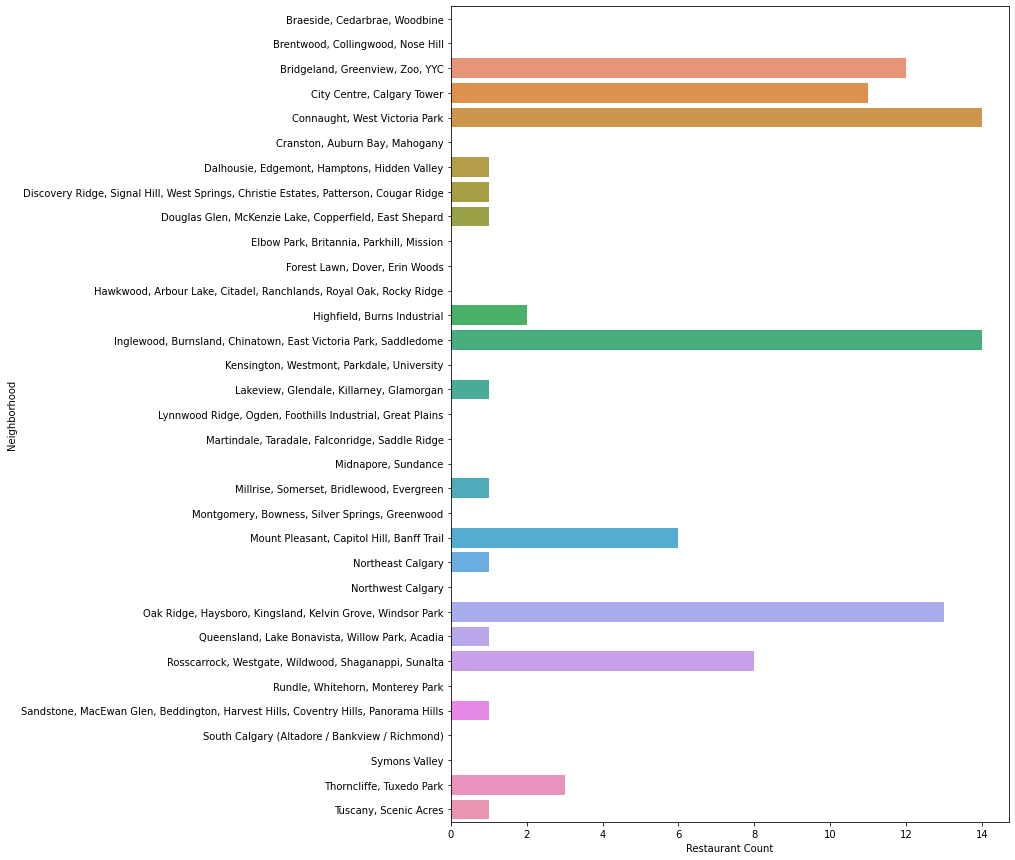

In [88]:
fig, ax = plt.subplots(figsize=(10,15))
sns.barplot(x="Restaurant Count", y="Neighborhood", data=nb_total, ax=ax)

From the bar plot above, the highest number of restaurants can be found in the neighborhoods of Connaught and Wester Victoria Park, as well as Inglewood, Burnsland, Chinatown, East Victoria Park and Saddledome.

In [89]:
city_grouped2 = city_onehot.groupby('Neighborhood').mean().reset_index()
city_grouped2

,Neighborhood,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Bistro,...,Sushi Restaurant,Tapas Restaurant,Tattoo Parlor,Thai Restaurant,Theater,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Shop,Yoga Studio
0,"Braeside, Cedarbrae, Woodbine",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,"Brentwood, Collingwood, Nose Hill",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Bridgeland, Greenview, Zoo, YYC",0.000000,0.000000,0.000000,0.045455,0.000000,0.000000,0.090909,0.000000,0.000000,...,0.045455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045455,0.000000,0.000000
3,"City Centre, Calgary Tower",0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.071429,0.000000,...,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035714,0.000000,0.000000
4,"Connaught, West Victoria Park",0.000000,0.000000,0.000000,0.000000,0.000000,0.023810,0.000000,0.071429,0.000000,...,0.023810,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023810
5,"Cranston, Auburn Bay, Mahogany",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,"Dalhousie, Edgemont, Hamptons, Hidden Valley",0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,"Discovery Ridge, Signal Hill, West Springs, Ch...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000
8,"Douglas Glen, McKenzie Lake, Copperfield, East...",0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.142857,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,"Elbow Park, Britannia, Parkhill, Mission",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Another dataframe `res_grp` is then created by extracting columns containing the string 'Restaurant' from the `city_grouped2` dataframe and the 'Neighbourhood' column was inserted first into that dataframe. This will be used in subsequent clustering analysis using the *k*-means algorithm.

In [90]:
res_grp = city_grouped2.loc[:,city_grouped1.columns.str.contains("Restaurant")]

In [91]:
res_grp.insert(loc=0, column='Neighborhood', value=cols)

In [92]:
res_grp.head()

,Neighborhood,American Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant,...,Moroccan Restaurant,New American Restaurant,Restaurant,Scandinavian Restaurant,Seafood Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,"Braeside, Cedarbrae, Woodbine",0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000
1,"Brentwood, Collingwood, Nose Hill",0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000
2,"Bridgeland, Greenview, Zoo, YYC",0.0,0.045455,0.00000,0.045455,0.045455,0.045455,0.090909,0.000000,0.045455,...,0.000000,0.0,0.045455,0.00000,0.045455,0.045455,0.0,0.0,0.0,0.045455
3,"City Centre, Calgary Tower",0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.035714,0.0,0.071429,0.00000,0.000000,0.071429,0.0,0.0,0.0,0.035714
4,"Connaught, West Victoria Park",0.0,0.000000,0.02381,0.023810,0.000000,0.000000,0.000000,0.047619,0.000000,...,0.023810,0.0,0.047619,0.02381,0.000000,0.023810,0.0,0.0,0.0,0.000000


In [93]:
res_clustering = res_grp.drop('Neighborhood', 1)

An initial clustering with 5 clusters was attempted

In [94]:
kclusters_res = 5
kmeans_res = KMeans(n_clusters=kclusters_res, random_state=42).fit(res_clustering)

The elbow method was used to try to find the optimum number of clusters for the algorithm. The point where the summed standard error curve starts to bend is known as the elbow point. This point is thought to be a reasonable trade-off between error generated and the number of clusters.

In [95]:
Sum_of_squared_distances = []
K = range(1,21)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(res_clustering)
    Sum_of_squared_distances.append(km.inertia_)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: ConvergenceWarning: Number of distinct clusters (19) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  """


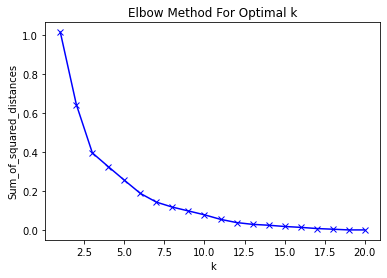

In [96]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The `Kneelocator` method from the **kneed library** was used to identify the optimal k. This is a better way instead of guessing the elbow point from the graph above.

In [97]:
kl = KneeLocator(range(1, 21), Sum_of_squared_distances, curve="convex", direction="decreasing")

In [98]:
print(kl.elbow)

6


Additionally the optimal number of iterations can be obtained using the `n_iter_n` method.

In [99]:
kmeans_res.n_iter_

2

Based on the information above, the following code cell generates the kmeans labels required for the data.

In [100]:
kclusters_res = 6
kmeans_res = KMeans(n_clusters=kclusters_res, max_iter = 2, random_state=42).fit(res_clustering)

The `res2` dataframe contains the information on the neighborhoods, their cluster labels and their coordinates (latitude and longitude).

In [101]:
res2 = city_grouped2[['Neighborhood']]
res2["Cluster Labels"] = kmeans_res.labels_
res2.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Neighborhood,Cluster Labels
0,"Braeside, Cedarbrae, Woodbine",1
1,"Brentwood, Collingwood, Nose Hill",1
2,"Bridgeland, Greenview, Zoo, YYC",1
3,"City Centre, Calgary Tower",1
4,"Connaught, West Victoria Park",1


In [102]:
res2['Latitude'] = calgary_data['Latitude']
res2['Longitude'] = calgary_data['Longitude']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [103]:
res2.head()

,Neighborhood,Cluster Labels,Latitude,Longitude
0,"Braeside, Cedarbrae, Woodbine",1,51.049680,-113.964320
1,"Brentwood, Collingwood, Nose Hill",1,51.126060,-114.143158
2,"Bridgeland, Greenview, Zoo, YYC",1,51.0318,-113.9786
3,"City Centre, Calgary Tower",1,51.0809,-114.1616
4,"Connaught, West Victoria Park",1,50.9878,-114.0001


The following code shows the top 10 venues in each neighborhood, sorted in descending order:

In [104]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = res_grp['Neighborhood']

for ind in np.arange(city_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(res_grp.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Braeside, Cedarbrae, Woodbine",Vietnamese Restaurant,Korean Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant
1,"Brentwood, Collingwood, Nose Hill",Vietnamese Restaurant,Korean Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant
2,"Bridgeland, Greenview, Zoo, YYC",Fast Food Restaurant,Vietnamese Restaurant,Asian Restaurant,Sushi Restaurant,Seafood Restaurant,Chinese Restaurant,Restaurant,Dim Sum Restaurant,Falafel Restaurant,Middle Eastern Restaurant
3,"City Centre, Calgary Tower",Mediterranean Restaurant,Restaurant,Sushi Restaurant,Italian Restaurant,Japanese Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,Vietnamese Restaurant,New American Restaurant,French Restaurant
4,"Connaught, West Victoria Park",Mediterranean Restaurant,Restaurant,Middle Eastern Restaurant,French Restaurant,Italian Restaurant,Brazilian Restaurant,Sushi Restaurant,Chinese Restaurant,Scandinavian Restaurant,Moroccan Restaurant


In [105]:
print('The neighborhoods_venues_sorted dataframe has', neighborhoods_venues_sorted.shape[0], 'rows and', neighborhoods_venues_sorted.shape[1], 'columns')

The neighborhoods_venues_sorted dataframe has 33 rows and 11 columns


A new dataframe that includes the cluster value and the top 10 venues for each neighborhood is generated using the code cell below.

In [106]:
city_merged = res2
city_merged = city_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

city_merged.head() # check the last columns!

,Neighborhood,Cluster Labels,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Braeside, Cedarbrae, Woodbine",1,51.049680,-113.964320,Vietnamese Restaurant,Korean Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant
1,"Brentwood, Collingwood, Nose Hill",1,51.126060,-114.143158,Vietnamese Restaurant,Korean Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant
2,"Bridgeland, Greenview, Zoo, YYC",1,51.0318,-113.9786,Fast Food Restaurant,Vietnamese Restaurant,Asian Restaurant,Sushi Restaurant,Seafood Restaurant,Chinese Restaurant,Restaurant,Dim Sum Restaurant,Falafel Restaurant,Middle Eastern Restaurant
3,"City Centre, Calgary Tower",1,51.0809,-114.1616,Mediterranean Restaurant,Restaurant,Sushi Restaurant,Italian Restaurant,Japanese Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,Vietnamese Restaurant,New American Restaurant,French Restaurant
4,"Connaught, West Victoria Park",1,50.9878,-114.0001,Mediterranean Restaurant,Restaurant,Middle Eastern Restaurant,French Restaurant,Italian Restaurant,Brazilian Restaurant,Sushi Restaurant,Chinese Restaurant,Scandinavian Restaurant,Moroccan Restaurant


The clusters can then be visualized on the map as below:

In [107]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters_res)
ys = [i + x + (i*x)**2 for i in range(kclusters_res)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(city_merged['Latitude'], city_merged['Longitude'], city_merged['Neighborhood'], city_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

---

## Part 3: Examining the clusters in Calgary, AB.

Each cluster is then examined to determine the discriminating venue categories that distinguish each cluster. To faciliate analysis, the columns 'Latitude' and 'Longitude' was dropped from the dataframe

In [108]:
city_merged_cleaned = city_merged.drop(['Latitude', 'Longitude'], axis=1)
city_merged_cleaned.head()

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Braeside, Cedarbrae, Woodbine",1,Vietnamese Restaurant,Korean Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant
1,"Brentwood, Collingwood, Nose Hill",1,Vietnamese Restaurant,Korean Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant
2,"Bridgeland, Greenview, Zoo, YYC",1,Fast Food Restaurant,Vietnamese Restaurant,Asian Restaurant,Sushi Restaurant,Seafood Restaurant,Chinese Restaurant,Restaurant,Dim Sum Restaurant,Falafel Restaurant,Middle Eastern Restaurant
3,"City Centre, Calgary Tower",1,Mediterranean Restaurant,Restaurant,Sushi Restaurant,Italian Restaurant,Japanese Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,Vietnamese Restaurant,New American Restaurant,French Restaurant
4,"Connaught, West Victoria Park",1,Mediterranean Restaurant,Restaurant,Middle Eastern Restaurant,French Restaurant,Italian Restaurant,Brazilian Restaurant,Sushi Restaurant,Chinese Restaurant,Scandinavian Restaurant,Moroccan Restaurant


To begin with, the number of neighborhoods for each cluster is shown by the code cell below. The results was assigned to the cluster_df dataframe and sorted

In [109]:
cluster_df = pd.DataFrame(city_merged_cleaned['Cluster Labels'].value_counts())

In [110]:
cluster_df.columns = ['Neighborhood Count']

In [111]:
cluster_df.sort_index()

,Neighborhood Count
0,3
1,23
2,1
3,3
4,1
5,2


#### Cluster 1

Cluster 1 has 3 neighborhoods with the top most common cuisine to be Asian (Vietnamese and Chinese).

In [112]:
city_merged_cleaned.loc[city_merged_cleaned['Cluster Labels'] == 0]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,"Mount Pleasant, Capitol Hill, Banff Trail",0,Vietnamese Restaurant,Sushi Restaurant,Chinese Restaurant,Fast Food Restaurant,Mediterranean Restaurant,American Restaurant,Scandinavian Restaurant,Asian Restaurant,Brazilian Restaurant,Thai Restaurant
25,"Queensland, Lake Bonavista, Willow Park, Acadia",0,Chinese Restaurant,Vietnamese Restaurant,Korean Restaurant,Asian Restaurant,Brazilian Restaurant,Dim Sum Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant
32,"Tuscany, Scenic Acres",0,Chinese Restaurant,Vietnamese Restaurant,Korean Restaurant,Asian Restaurant,Brazilian Restaurant,Dim Sum Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant


#### Cluster 2

There are 23 neighborhoods in this cluster with Vietnamese cuisine being the top cuisine.

In [113]:
city_merged_cleaned.loc[city_merged_cleaned['Cluster Labels'] == 1]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Braeside, Cedarbrae, Woodbine",1,Vietnamese Restaurant,Korean Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant
1,"Brentwood, Collingwood, Nose Hill",1,Vietnamese Restaurant,Korean Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant
2,"Bridgeland, Greenview, Zoo, YYC",1,Fast Food Restaurant,Vietnamese Restaurant,Asian Restaurant,Sushi Restaurant,Seafood Restaurant,Chinese Restaurant,Restaurant,Dim Sum Restaurant,Falafel Restaurant,Middle Eastern Restaurant
3,"City Centre, Calgary Tower",1,Mediterranean Restaurant,Restaurant,Sushi Restaurant,Italian Restaurant,Japanese Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,Vietnamese Restaurant,New American Restaurant,French Restaurant
4,"Connaught, West Victoria Park",1,Mediterranean Restaurant,Restaurant,Middle Eastern Restaurant,French Restaurant,Italian Restaurant,Brazilian Restaurant,Sushi Restaurant,Chinese Restaurant,Scandinavian Restaurant,Moroccan Restaurant
5,"Cranston, Auburn Bay, Mahogany",1,Vietnamese Restaurant,Korean Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant
9,"Elbow Park, Britannia, Parkhill, Mission",1,Vietnamese Restaurant,Korean Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant
10,"Forest Lawn, Dover, Erin Woods",1,Vietnamese Restaurant,Korean Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant
11,"Hawkwood, Arbour Lake, Citadel, Ranchlands, Ro...",1,Vietnamese Restaurant,Korean Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant
13,"Inglewood, Burnsland, Chinatown, East Victoria...",1,Italian Restaurant,Asian Restaurant,Restaurant,New American Restaurant,American Restaurant,Seafood Restaurant,Falafel Restaurant,Middle Eastern Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant


#### Cluster 3

There is only one neighborhood in this cluster with an American restaurant as the top cuisine.

In [114]:
city_merged_cleaned.loc[city_merged_cleaned['Cluster Labels'] == 2]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Northeast Calgary,2,American Restaurant,Korean Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant


#### Cluster 4

There are three neighborhoods in Cluster 4 and Vietnamese cuisine dominates this cluster.

In [115]:
city_merged_cleaned.loc[city_merged_cleaned['Cluster Labels'] == 3]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,"Discovery Ridge, Signal Hill, West Springs, Ch...",3,Vietnamese Restaurant,Korean Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant
15,"Lakeview, Glendale, Killarney, Glamorgan",3,Vietnamese Restaurant,Korean Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant
31,"Thorncliffe, Tuxedo Park",3,Vietnamese Restaurant,Fast Food Restaurant,Korean Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Falafel Restaurant,French Restaurant,Indian Restaurant


#### Cluster 5

There is only one neighborhood in Cluster 5 with an American restaurant as the top cuisine.

In [116]:
city_merged_cleaned.loc[city_merged_cleaned['Cluster Labels'] == 4]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,"Highfield, Burns Industrial",4,American Restaurant,Middle Eastern Restaurant,Korean Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant


#### Cluster 6

There is two neighborhoods in Cluster 6 with Asian restaurants as the top cuisine.

In [117]:
city_merged_cleaned.loc[city_merged_cleaned['Cluster Labels'] == 5]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,"Dalhousie, Edgemont, Hamptons, Hidden Valley",5,Asian Restaurant,Vietnamese Restaurant,Korean Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant
8,"Douglas Glen, McKenzie Lake, Copperfield, East...",5,Asian Restaurant,Vietnamese Restaurant,Korean Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant
